In [1]:
import numpy as np
import matplotlib.pylab as plt
import pims
import pandas as pd
from skimage import io
import os
import glob
import math
from scipy import stats
import pg_analysis.plotter as pga
from scipy.signal import savgol_filter

In [2]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection

def color_coded_plot3D(x, y, z, axis, t=None):
    if t is None:
        t = np.arange(0, x.shape[0])
    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 3 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 3 (for x, y, and z)
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(t.min(), t.max())
    lc = Line3DCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(t)
    lc.set_linewidth(2)
    line = axis.add_collection3d(lc)
    axis.set_xlim(np.min(x), np.max(x))
    axis.set_ylim(np.min(y), np.max(y))
    axis.set_zlim(np.min(z), np.max(z))
    return line

def motion_correction(R,G):
    # Implement motion correction: assumes that F_mc = (G(t)-alpha*R(t)) - <(G(t)-alpha*R(t))>_t. In this case, if no artefacts were present, R(t) is constant and would not change G(t).
    # Compute alpha - analytically minimize (R(t)-alpha*G(t))**2
    alpha = np.sum(R * G, axis=0) / np.sum(R ** 2, axis=0) #(we will have a space-dependent alpha as we have the larvae exprience different illumination etc in each area)
    R0 = np.mean(G - alpha * R, axis=0)
    # Compute Fmc
    Fmc = ((G - alpha * R) - R0)
    
    return Fmc

def dros_orientation(centerline):
    """ Get all images into the same orientation by comparing to a sample image."""
    sample = centerline[0]
    similarity = np.zeros(len(centerline))
    for idx, cl in enumerate(centerline):
        current = cl
        sim = np.sum((current-sample)**2)<\
            np.sum((current-sample[::-1])**2)
        similarity[idx] = sim
        if sim:
            sample = current
        else:
            sample = current[::-1]
    return similarity


def flip(similarity, data):
    """flips a kymograph if the similarity of the centerline was wrong. returns flipped data."""
    tmp = []
    for idx, entry in enumerate(similarity):
        if entry:
            tmp.append(data[idx])
        else:
            tmp.append(data[idx][::-1])
    return np.array(tmp)

def flipLR(similarity, data):
    """flips an image if the similarity of the centerline was wrong. returns flipped data."""
    tmp = []
    for idx, entry in enumerate(similarity):
        if entry:
            print(idx, entry)
            tmp.append(data[idx])
        else:
            tmp.append(data[idx][:,::-1])
    return np.array(tmp)

def odorGradient(x,y, t, D, x0=0, y0=0, Cmax = 100):
    # Assume isotropic 2D diffusion of the bacterial secretions. This should be ok for long distances, but the finite size might make a difference.
    #Diacetyl diffusion constant: DDA 2.52 × 10−4
    #cm2/s Diacetyl diffusion coefficient
    #from:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5147516/
    return Cmax*np.exp(-((x-x0)**2 + (y-y0)**2)/(4*D*t))

def readResultsfiles(path, fname):
    tracks = pd.read_json(os.path.join(path, fname), orient='split')
    # create straightened images
    straight_red = np.array([np.array(x) for x in tracks['Straightened_red'].values])
    straight_green = np.array([np.array(x) for x in tracks['Straightened_green'].values])
    #
    #contour = np.array([np.array(x) for x in tracks['Contour'].values])*scale
    centerline = np.array([np.array(x) for x in tracks['Centerline'].values])
    # 
    # recalculate kymo from straightened
    kymo_red = np.mean(straight_red, axis=2).T
    kymo_green = np.mean(straight_green, axis=2).T
    # ratiometric images
    ratio = straight_green/straight_red
    R0 = np.percentile(ratio, [20])[0]#[:,np.newaxis, np.newaxis]
    ratio -= R0
    ratio/= R0
    # ratiometric kymograph
    kymo_ratio = np.mean(ratio, axis=2).T
    return straight_red, straight_green, centerline, kymo_red, kymo_green, kymo_ratio

def createScaleAndRotationMatrix(scale: float, rotation: float, center_rot_x: float, center_rot_y: float) -> np.ndarray:
    """Create 2D scale-and-rotation matrix around a specified center of rotation.

    Args:
        scale (float): scaling
        rotation (float): rotation angle in radian
        center_rot_x (float): center of rotation in X axis
        center_rot_y (float): center of rotation in Y axis

    Returns:
        matrix (np.ndarray): A 3x3 transformation matrix.
    """    
    cos = scale * math.cos(rotation)
    sin = scale * math.sin(rotation)

    matrix = np.array([
        [ cos,    -sin,      (1-cos) * center_rot_x + sin * center_rot_y ],
        [ sin,     cos,      (1-cos) * center_rot_y - sin * center_rot_x ],
        [ 0,        0,       1]
    ], np.float32)

    return matrix

In [3]:
movie = 'Drosophila_larvae_vinaigre_09'
outPath = '/gpfs/soma_fs/home/scholz/scratch/drosophila/'
inpath = f'/gpfs/soma_fs/nif/nif9201.bak/Euphrasie/Tracking experiment/Drosophila tracks/Successful/{movie}/'
outfile = f'{movie}_results.json'
scale = 2.4/1000

In [4]:
%%time
tracks = pd.read_json(outPath+outfile, orient='split')

CPU times: user 59.4 s, sys: 10.7 s, total: 1min 10s
Wall time: 1min 13s


In [5]:
# load correspoding x,y track
coordsfile = glob.glob(inpath+'*coords.txt')[0]
stage = pd.read_csv(coordsfile, delimiter=' ')

In [8]:
stage

,Frame,Time,X,Y,Z,Unnamed: 5
0,0,7413227.3,65.269626,71.333653,68.625641,NaN
1,1,7413278.3,65.269626,71.333653,68.625641,NaN
2,2,7413329.3,65.434410,71.333653,68.625641,NaN
3,3,7413380.4,65.434410,71.476744,68.625641,NaN
4,4,7413431.4,65.434410,71.476744,68.625641,NaN
...,...,...,...,...,...,...
6100,6100,7724522.5,92.216023,135.797731,68.056869,NaN
6101,6101,7724573.5,92.216023,135.797731,68.056869,NaN
6102,6102,7724624.5,92.216023,135.797731,68.056869,NaN
6103,6103,7724675.6,92.216023,135.797731,68.056869,NaN


In [9]:
tracks

,Centerline,Contour,Straightened_red,Straightened_green,frame
0,"[[814.5854271892, 352.6387412675], [810.420968...","[[813.5, 360.0], [813.5, 359.0], [813.5, 358.0...","[[24.5, 22.0, 21.0, 22.5, 21.0, 19.5, 21.5, 24...","[[9.5, 10.0, 12.0, 12.5, 11.5, 12.5, 13.0, 13....",0
1,"[[819.4723647622, 352.3254343011], [815.262222...","[[821.0, 354.5], [820.5, 355.0], [820.5, 356.0...","[[28.0, 24.0, 17.0, 20.0, 23.0, 23.0, 17.0, 20...","[[18.0, 15.0, 14.0, 14.0, 15.0, 16.0, 15.0, 14...",1
2,"[[819.027638965, 356.3491325763], [814.7745552...","[[824.5, 350.0], [824.5, 349.0], [824.5, 348.0...","[[24.0, 21.0, 18.5, 18.5, 22.0, 26.5, 24.5, 22...","[[16.5, 13.0, 14.0, 15.5, 16.0, 20.0, 21.0, 20...",2
3,"[[816.1507525029, 351.4588693025], [811.824880...","[[817.0, 348.5], [816.5, 349.0], [816.5, 350.0...","[[23.0, 23.0, 20.0, 20.0, 18.0, 16.0, 20.0, 23...","[[13.0, 9.0, 11.0, 12.0, 10.0, 11.0, 16.0, 12....",3
4,"[[788.2763840238, 351.5726861249], [783.927365...","[[789.5, 356.0], [789.5, 355.0], [789.5, 354.0...","[[21.0, 20.5, 21.0, 23.0, 25.0, 25.5, 23.5, 21...","[[19.5, 19.5, 17.0, 18.0, 17.0, 15.0, 17.0, 18...",4
...,...,...,...,...,...
6100,"[[624.8557742698, 323.7144902222], [620.996813...","[[628.0, 338.5], [627.5, 339.0], [627.5, 340.0...","[[35.5, 35.5, 32.0, 28.5, 34.0, 40.5, 40.5, 38...","[[16.5, 16.0, 16.0, 17.0, 15.5, 14.5, 16.5, 18...",6100
6101,"[[635.5443582136, 302.4807573217], [631.685701...","[[636.5, 327.0], [636.5, 326.0], [636.5, 325.0...","[[31.0, 32.0, 36.0, 38.0, 35.0, 32.0, 32.0, 42...","[[20.0, 18.0, 20.0, 20.0, 21.0, 20.0, 20.0, 23...",6101
6102,"[[632.165219884, 288.2363579532], [628.4686999...","[[637.0, 315.5], [636.5, 316.0], [636.5, 317.0...","[[37.0, 33.0, 36.5, 39.5, 37.0, 32.0, 29.5, 35...","[[22.0, 22.0, 22.0, 21.5, 19.5, 19.0, 20.5, 20...",6102
6103,"[[630.6296628234, 288.6034535368], [627.037886...","[[636.5, 315.0], [636.5, 314.0], [636.5, 313.0...","[[30.0, 35.0, 34.0, 39.0, 38.0, 40.0, 33.0, 35...","[[18.0, 17.0, 15.0, 15.0, 15.0, 12.0, 11.0, 16...",6103


In [10]:
tracks['x'] = stage['X']
tracks['y'] = stage['Y']

In [11]:
%%time
# create straightened images
straight_red = np.array([np.array(x) for x in tracks['Straightened_red'].values])
straight_green = np.array([np.array(x) for x in tracks['Straightened_green'].values])
#
contour = np.array([np.array(x) for x in tracks['Contour'].values])*scale
# recalculate kymo from straightened
kymo_red = np.mean(straight_red, axis=2).T
kymo_green = np.mean(straight_green, axis=2).T
# ratiometric images
ratio = straight_green/straight_red
R0 = np.percentile(ratio, [20], axis=(2,1))[0][:,np.newaxis, np.newaxis]
ratio -= R0
ratio/= R0

# ratiometric kymograph
kymo_ratio = np.mean(ratio, axis=2).T

CPU times: user 27 s, sys: 4.59 s, total: 31.6 s
Wall time: 31.8 s


In [12]:
#
centerline = np.array([np.array(x) for x in tracks['Centerline'].values])

## Show a contour

In [13]:
# align contour with camera -- use rotation angle
# camera angle to stage ~ 45 degree
mat = createScaleAndRotationMatrix(1, np.pi/4, 0,0)[:2,:2]

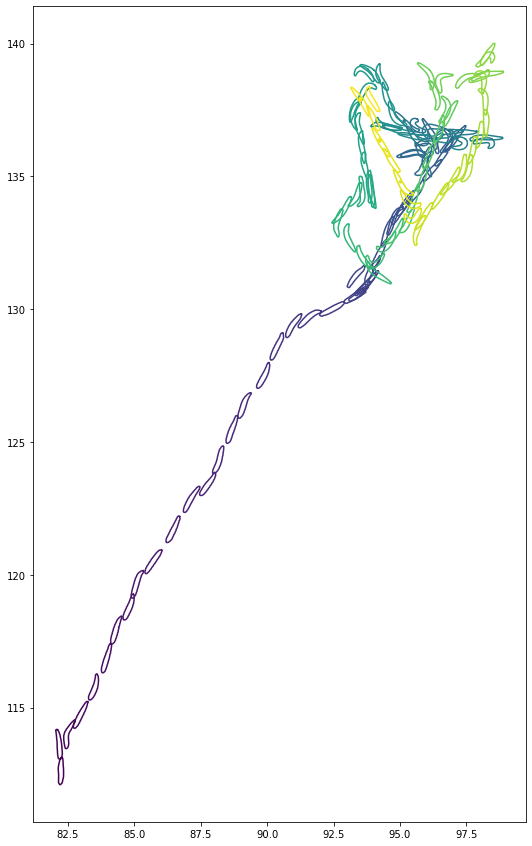

In [14]:
# plot contour over time.
#NOTE: NEED CALIBRATION matrix to make this correct. Current one is ok
t0 = 1500
maxt = 5000
dt = 30
times = np.arange(t0, maxt, dt)
cmap = plt.cm.viridis
plt.figure(figsize=(18,15))
plt.gca().set_aspect( 1)
for t in times:
    cp = contour[t].T
    cp = mat @ cp
    plt.plot(cp[0]+tracks['x'][t], cp[1]+tracks['y'][t], color=cmap((t-t0)/(maxt-t0)))
#plt.savefig(f'{movie}_{t0}_{maxt}_dt={dt}_contours.svg')

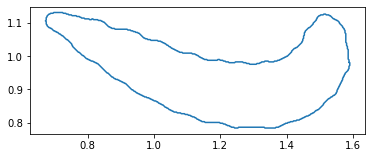

In [15]:
plt.plot(contour[5900][:,0],contour[5900][:,1])
plt.gca().set_aspect(1)
plt.savefig(f'Contour_{movie}_5900.svg')

## Straightened larvae with a clear wave. 

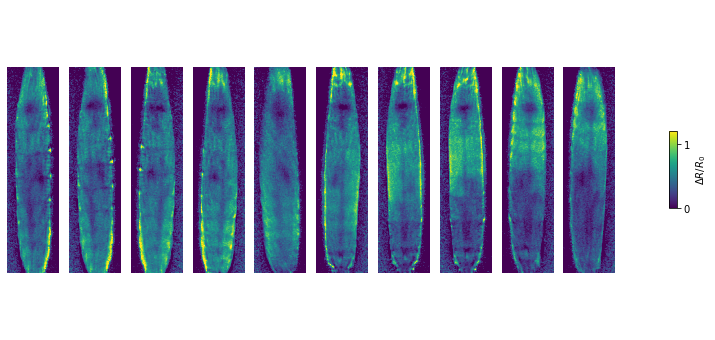

In [16]:
f, axes = plt.subplots(1,11, figsize=(12,6))
offset=10
for i in range(10):
    im = axes[i].imshow(ratio[i+offset], aspect = 2, cmap='viridis', vmin = 0.0, vmax=1.2)
    axes[i].axis('off')
plt.colorbar(im, ax = axes[10], aspect=10, ticks=[0,1,2,3], label= "$\Delta R/R_0$", panchor=[0,0], location = 'right')
axes[10].axis('off');
plt.savefig(f'{movie}_ratiometric_straightened.svg')

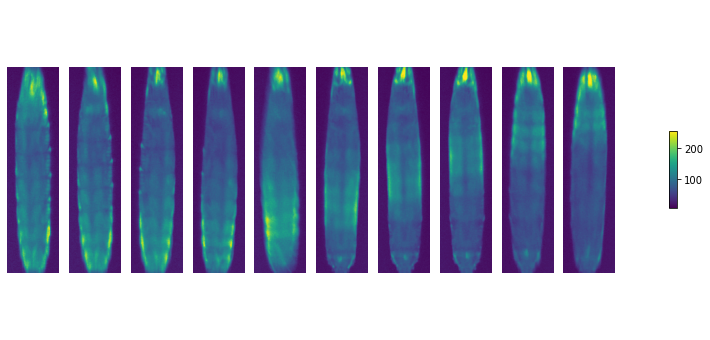

In [17]:
f, axes = plt.subplots(1,11, figsize=(12,6))
for i in range(10):
    im = axes[i].imshow(straight_green[i+offset], aspect = 2, cmap='viridis')#, vmin = -0, vmax=3)
    axes[i].axis('off')
plt.colorbar(im, ax = axes[10], aspect=10)#, ticks=[0,1,2,3], label= "$\Delta R/R_0$", panchor=[0,0], location = 'right')
axes[10].axis('off');
plt.savefig(f'{movie}_gcamp_straightened.svg')

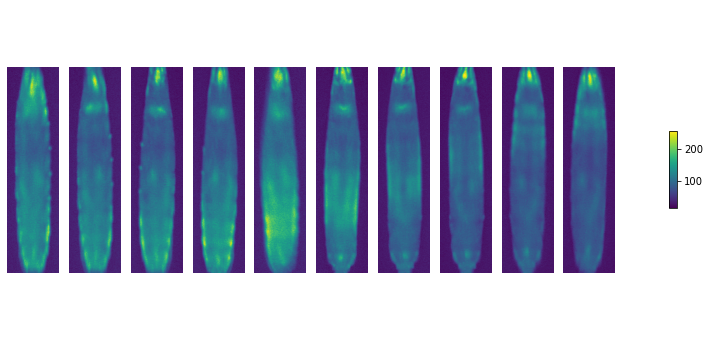

In [18]:
f, axes = plt.subplots(1,11, figsize=(12,6))
for i in range(10):
    im = axes[i].imshow(straight_red[i+offset], aspect = 2, cmap='viridis')#, vmin = -0, vmax=3)
    axes[i].axis('off')
plt.colorbar(im, ax = axes[10], aspect=10)#, ticks=[0,1,2,3], label= "$\Delta R/R_0$", panchor=[0,0], location = 'right')
axes[10].axis('off');
plt.savefig(f'{movie}_red_straightened.svg')

In [19]:
# short piece of kymograph

(299.5, -0.5)


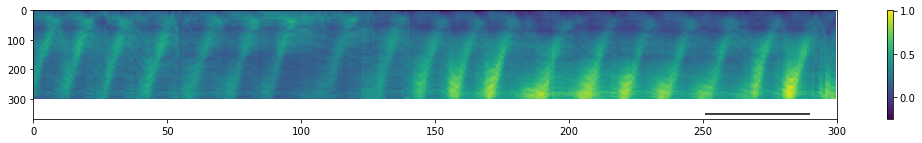

In [20]:
f, axes = plt.subplots(1,1, figsize=(18,2))
plt.imshow(np.mean(ratio[:300], axis=2).T, aspect='auto')
plt.xlim(0,300)
plt.colorbar()
# add a scalebar
scale = 1/19.6 #(fps)
scalebar = 2 # s
l = scalebar/scale
ax = plt.gca()
xmax = ax.get_xlim()[1]
print(ax.get_ylim())
ax.hlines(ax.get_ylim()[0]+50, xmax-l-10, xmax-10, color = 'k', zorder=10)
plt.savefig(f'{movie}_kymograph_0_300frames_scalebar_2s.svg')

# show the kymograph

In [21]:
sim = dros_orientation(centerline)
kymo_ratio2= flip(sim, kymo_ratio.T).T

In [22]:
sim.shape
kymo_ratio.shape

(300, 6105)

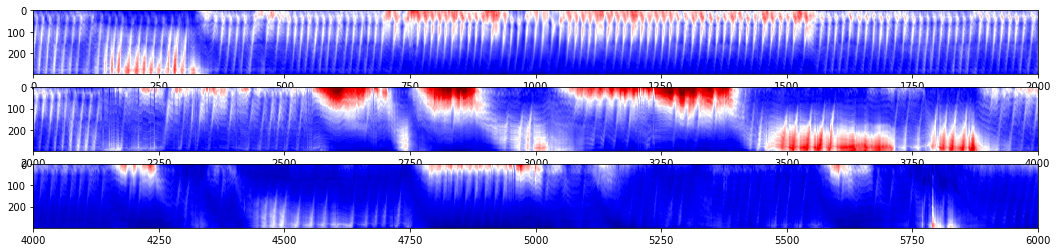

In [23]:
#ratio = (kymo_green_2-kymo_red_2)#/np.median(kymo_red, axis =0)*100#[:,np.newaxis]#/(kymo_red_2.mean())
ratio[~np.isfinite(ratio)] = 0
f, ax = plt.subplots(3,1, figsize=(18,4))
ax[0].imshow(kymo_ratio2, aspect='auto', vmin=-0.5, vmax=1.5, cmap='seismic')
ax[0].set_xlim(0,2000)
ax[1].imshow(kymo_ratio2, aspect='auto', vmin=-0.5, vmax=1.5, cmap='seismic')
ax[1].set_xlim(2000,4000)
ax[2].imshow(kymo_ratio2, aspect='auto', vmin=-0.5, vmax=2.5, cmap='seismic')
ax[2].set_xlim(4000,6000);

## Read all tracks

In [4]:
import pg_analysis.plotter as pga
units = {'x': 'mm',
 'y': 'mm',
 'frame': 1,
 'pumps': 'a.f.u.',
 'Istd': 'a.f.u.',
 'Centerline': '1',
 'Straightened': 1,
 'area': 'px^2',
 'temperature': 'C',
 'humidity': '%',
 'size': 'mm',
 'age': 'h',
 '@acclimation': 'min'}

In [25]:
# load correspoding x,y track
inpath = f'/gpfs/soma_fs/nif/nif9201.bak/Euphrasie/Tracking experiment/Drosophila tracks/Successful/'
folders = [f for f in os.listdir(inpath) if os.path.isdir(inpath+f)]
# remove 03
folders

inpath2 = f'/gpfs/soma_fs/nif/nif9201.bak/Euphrasie/Tracking experiment/Drosophila tracks/Unsuccessful/'
folders2 = [f for f in os.listdir(inpath2) if os.path.isdir(inpath2+f)]
folders2

['Drosophila_larvae_vinaigre_026',
 'Drosophila_larvae_vinegre_016',
 'Drosophila_larvae_vinaigre_032',
 'Drosophila_larvae_vinaigre_037',
 'Drosophila_larvae_vinaigre_029',
 'Drosophila_larvae_vinaigre_027',
 'Drosophila_larvae_vinaigre_035',
 'Drosophila_larvae_vinaigre_043',
 'Drosophila_larvae_vinaigre_031',
 'Drosophila_larvae_vinaigre_036',
 'Drosophila_larvae_vinaigre_039',
 'Drosophila_larvae_vinegre_013',
 'Drosophila_larvae_vinegre_08']

In [26]:
folders

['Drosophila_larvae_vinaigre_017',
 'Drosophila_vinaigre_053',
 'Drosophila_larvae_vinaigre_023',
 'Drosophila_larvae_vinaigre_040',
 'Drosophila_larvae_vinaigre_09',
 'Drosophila_vinaigre_051',
 'Drosophila_larvae_vinaigre_011',
 'Drosophila_larvae_vinaigre_018',
 'Drosophila_larvae_vinaigre_044',
 'Drosophila_larvae_vinaigre_022']

In [28]:
# load metadta of odor spots
metadata = pd.read_excel(inpath+'Metadata_Drosophila_Tracks.xlsx', header=1, skiprows=lambda x:x in [2])
metadata = metadata.set_index('Recording_ID')
metadata = metadata.rename(index={'Drosophila_larvae_vinaigre_020': 'Drosophila_larvae_vinaigre_023'})

# load metadta of odor spots
metadata2 = pd.read_excel(inpath2+'Metadata_Drosophila_UnsuccessfulTracks.xlsx', header=1, skiprows=lambda x:x in [2])
metadata2 = metadata2.set_index('Recording_ID')
#metadata2 = metadata2.rename(index={'Drosophila_larvae_vinaigre_020': 'Drosophila_larvae_vinaigre_023'})

In [29]:
metadata2

,Strain,condition,Vinaigre Concentration,Drop position,Stage,Sync_day,sync_end,sync_egg_laying_duration,Sync_Temperature,sync_observation,...,Unnamed: 1005,Unnamed: 1006,Unnamed: 1007,Unnamed: 1008,Unnamed: 1009,Unnamed: 1010,Unnamed: 1011,Unnamed: 1012,Unnamed: 1013,Unnamed: 1014
Recording_ID,,,,,,,,,,,,,,,,,,,,,
Drosophila_larvae_vinaigre_026,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,51.33 76.42,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_029,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,22.08 81.37,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_031,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,40.06 80.15\n,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_032,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,68.21 131.90,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_036,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,54.76 78.82,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_037,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,54.76 78.82,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_039,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,6.80 109.08,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drosophila_larvae_vinaigre_043,"MEF2-Gal4, UAS-mGerry",OFF FOOD,100% undiluted,60.94 101.67,Btw early - late 2sd instar larvea,No sync,NaN,NaN,25C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Read successful tracks

In [30]:
# 1.5 um/px
control = pga.Experiment(strain='GCaMP', condition='Vinegar', scale=1, fps = 19.6)
control.load_data('/', units=units)

for mindex, movie in enumerate(folders):
    coordsfile = glob.glob(os.path.join(inpath,movie,'*coords.txt'))[0]
    stage = pd.read_csv(coordsfile, delimiter=' ')
    w = pga.Worm('', columns=None, fps=control.fps, scale=control.scale, units=units, particle_index = mindex, load = False)
    w.experimentID = movie
    tmp = pd.DataFrame()
    tmp['x'] = stage['X'] # units of um
    tmp['y'] = stage['Y']
    if len(tmp['x'])<6103:
        continue
    try:
        drop = np.array([float(x) for x in metadata.loc[movie, 'Drop position'].split(',')])
    except KeyError:
        print(movie)
        continue
        drop = tmp['x'][-300:].mean(), tmp['y'][-300:].mean()
        print(drop, movie)
    tmp['x_spot'] = tmp['x'] - drop[0]
    tmp['y_spot'] = tmp['y'] - drop[1]
    tmp['frame'] = stage.index
    w.data = tmp
    control.samples.append(w)

In [32]:
del tracks, centerline

NameError: name 'tracks' is not defined

In [33]:
%%time
outPath = '/gpfs/soma_fs/home/scholz/scratch/drosophila/'
for worm in control.samples:
    movie = worm.experimentID
    fname = f'{movie}_results.json'
    straight_red, straight_green, centerline, kymo_red, kymo_green, kymo_ratio = readResultsfiles(outPath, fname)
    # flip as needed
    sim = dros_orientation(centerline)
    worm.straight_red = flip(sim, straight_red)
    worm.straight_green = flip(sim, straight_green)
    worm.centerline = centerline
    worm.kymo_green = flip(sim, kymo_green.T)
    worm.kymo_red = flip(sim, kymo_red.T)
    worm.kymo_ratio = flip(sim, kymo_ratio.T)
    print(len(worm.centerline), worm.experimentID, len(worm.data))
    lengths = worm.scale/1000*np.sum(np.sum(np.diff(worm.centerline, axis=1)**2, axis=1)**2, axis=1)**0.5
    # this is the length of the centerline in mm
    lengths = np.pad(lengths, (0, len(worm.data)-len(lengths)), mode='mean')
    worm.data['length'] = lengths
    print(f'Done {movie}')

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_017 6105
Done Drosophila_larvae_vinaigre_017


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_vinaigre_053 6105
Done Drosophila_vinaigre_053
6103 Drosophila_larvae_vinaigre_023 6105
Done Drosophila_larvae_vinaigre_023


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_040 6105
Done Drosophila_larvae_vinaigre_040
6105 Drosophila_larvae_vinaigre_09 6105
Done Drosophila_larvae_vinaigre_09


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_vinaigre_051 6105
Done Drosophila_vinaigre_051
6105 Drosophila_larvae_vinaigre_011 6105
Done Drosophila_larvae_vinaigre_011
6105 Drosophila_larvae_vinaigre_018 6105
Done Drosophila_larvae_vinaigre_018


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_044 6105
Done Drosophila_larvae_vinaigre_044
6105 Drosophila_larvae_vinaigre_022 6105
Done Drosophila_larvae_vinaigre_022
CPU times: user 16min 31s, sys: 4min 4s, total: 20min 36s
Wall time: 20min 53s


### Read unsuccessful tracks

In [34]:
random = pga.Experiment(strain='GCaMP', condition='Vinegar', scale=1, fps = 19.6)
random.load_data('/', units=units)

for mindex, movie in enumerate(folders2):
    coordsfile = glob.glob(os.path.join(inpath2,movie,'*coords.txt'))[0]
    stage = pd.read_csv(coordsfile, delimiter=' ')
    w = pga.Worm('', columns=None, fps=control.fps, scale=control.scale, units=units, particle_index = mindex, load = False)
    w.experimentID = movie
    tmp = pd.DataFrame()
    tmp['x'] = stage['X'] # units of um
    tmp['y'] = stage['Y']
    # drop short movies
    if len(tmp['x'])<6103:
        continue
    try:
        drop = np.array([float(x) for x in metadata2.loc[movie, 'Drop position'].split(' ')])
    except KeyError:
        drop = tmp['x'][-300:].mean(), tmp['y'][-300:].mean()
        print(movie, drop)
    tmp['x_spot'] = tmp['x'] - drop[0]
    tmp['y_spot'] = tmp['y'] - drop[1]
    tmp['frame'] = stage.index
    w.data = tmp
    random.samples.append(w)

Drosophila_larvae_vinegre_016 (39.94428418776435, 73.33201426645522)
Drosophila_larvae_vinegre_013 (23.124360122103116, 124.3652710077425)
Drosophila_larvae_vinegre_08 (100.44659550449923, 136.26711996810627)


In [35]:
%%time
outPath = '/gpfs/soma_fs/home/scholz/scratch/drosophila/'
for worm in random.samples:
    movie = worm.experimentID
    fname = f'{movie}_results.json'
    straight_red, straight_green, centerline, kymo_red, kymo_green, kymo_ratio = readResultsfiles(outPath, fname)
    # flip as needed
    sim = dros_orientation(centerline)
    # flip left- right
    sim_left_right = dros_orientation(straight_red[:,straight_red.shape[1]//2,])
    worm.straight_red = flip(sim, straight_red)
    worm.straight_green = flip(sim, straight_green)
    worm.centerline = centerline
    worm.kymo_green = flip(sim, kymo_green.T)
    worm.kymo_red = flip(sim, kymo_red.T)
    worm.kymo_ratio = flip(sim, kymo_ratio.T)
    print(len(worm.centerline), worm.experimentID, len(worm.data))
    lengths = worm.scale/1000*np.sum(np.sum(np.diff(worm.centerline, axis=1)**2, axis=1)**2, axis=1)**0.5
    # this is the length of the centerline in mm
    lengths = np.pad(lengths, (0, len(worm.data)-len(lengths)), mode='mean')
    worm.data['length'] = lengths
    print(f'Done {movie}')

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_026 6105
Done Drosophila_larvae_vinaigre_026


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


6105 Drosophila_larvae_vinegre_016 6105
Done Drosophila_larvae_vinegre_016


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_032 6105
Done Drosophila_larvae_vinaigre_032


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_037 6105
Done Drosophila_larvae_vinaigre_037


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_043 6105
Done Drosophila_larvae_vinaigre_043


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_031 6105
Done Drosophila_larvae_vinaigre_031


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinaigre_039 6105
Done Drosophila_larvae_vinaigre_039
6105 Drosophila_larvae_vinegre_013 6105
Done Drosophila_larvae_vinegre_013


/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


6105 Drosophila_larvae_vinegre_08 6105
Done Drosophila_larvae_vinegre_08
CPU times: user 14min 50s, sys: 4min 16s, total: 19min 6s
Wall time: 19min 31s


In [36]:
control

Experiment 
 Strain: GCaMP,
 Condition: Vinegar
 N = 10.

In [37]:
random

Experiment 
 Strain: GCaMP,
 Condition: Vinegar
 N = 9.

In [2167]:
# calculate extra stuff
control.calculate_property('time') # uses fps to get frame -> seconds
control.calculate_property('velocity', dt=20)
control.calculate_property('smoothed', key='velocity', window=200)
# calculate extra stuff
random.calculate_property('time') # uses fps to get frame -> seconds
random.calculate_property('velocity', dt=20)
random.calculate_property('smoothed', key='velocity', window=200)

# calculate odor reconstruction -- D = 0.105  cm2 s−1 vinegar in air
for worm in control.samples:
    x,y = worm.data['x_spot'], worm.data['y_spot']
    odor = odorGradient(x/10,y/10, t=10*60, D=0.105, x0=0, y0=0, Cmax = 100)
    worm.data['odor'] = odor

for worm in random.samples:
    x,y = worm.data['x_spot'], worm.data['y_spot']
    odor = odorGradient(x/10,y/10, t=10*60, D=0.105, x0=0, y0=0, Cmax = 100)
    worm.data['odor'] = odor

# calculate motion correction
for worm in control.samples:
    worm.Fmc = motion_correction(worm.kymo_red,worm.kymo_green)

for worm in random.samples:
    worm.Fmc = motion_correction(worm.kymo_red,worm.kymo_green)

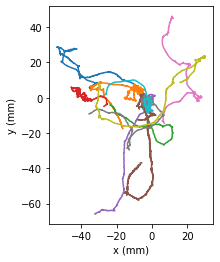

In [39]:
f, ax = plt.subplots(1,1)
ax.set_aspect(1)
control.plot(ax, ['x_spot', 'y_spot'], metric=None);
plt.setp(ax, xlabel = 'x (mm)', ylabel = 'y (mm)');
#plt.savefig('Tracks_successful.svg')

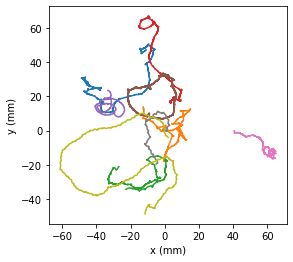

In [40]:
f, ax = plt.subplots(1,1)
ax.set_aspect(1)
random.plot(ax, ['x_spot', 'y_spot'], metric=None);
plt.setp(ax, xlabel = 'x (mm)', ylabel = 'y (mm)');
#plt.savefig('Tracks_unsuccessful.svg')

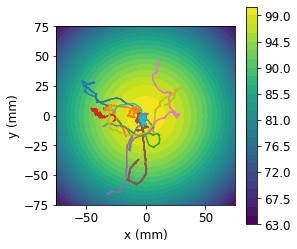

In [21]:
#odor = odorGradient(x/10,y/10, t=10*60, D=0.105, x0=0, y0=0, Cmax = 100)

t = 10*60
D = 0.105 #cm^2/s
x = np.linspace(-75, 75, 101)
y = np.linspace(-75, 75, 101)
# full coordinate arrays
xx, yy = np.meshgrid(x, y)
zz = odorGradient(xx/10,yy/10, t, D, x0=0, y0=0)

# figure
f, ax = plt.subplots(1, 1, figsize=(4,4))
h = ax.contourf(xx, yy, zz, levels=35)
ax.set_aspect(1)
plt.setp(ax, xlabel='x (cm)', ylabel='y (cm)')
plt.colorbar(h, ax=ax)
control.plot(ax, ['x_spot', 'y_spot'], metric=None);
plt.setp(ax, xlabel = 'x (mm)', ylabel = 'y (mm)');
plt.savefig('control_gradient.svg')

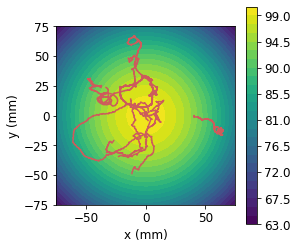

In [20]:
#odor = odorGradient(x/10,y/10, t=10*60, D=0.105, x0=0, y0=0, Cmax = 100)

t = 10*60
D = 0.105 #cm^2/s
x = np.linspace(-75, 75, 101)
y = np.linspace(-75, 75, 101)
# full coordinate arrays
xx, yy = np.meshgrid(x, y)
zz = odorGradient(xx/10,yy/10, t, D, x0=0, y0=0)

# figure
f, ax = plt.subplots(1, 1, figsize=(4,4))
h = ax.contourf(xx, yy, zz, levels=35)
ax.set_aspect(1)
plt.setp(ax, xlabel='x (cm)', ylabel='y (cm)')
plt.colorbar(h, ax=ax)
random.plot(ax, ['x_spot', 'y_spot'], metric=None);
plt.setp(ax, xlabel = 'x (mm)', ylabel = 'y (mm)');
plt.savefig('Random_gradient.svg')

findfont: Font family ['roboto'] not found. Falling back to DejaVu Sans.


MannwhitneyuResult(statistic=49.0, pvalue=0.7750513736700824)


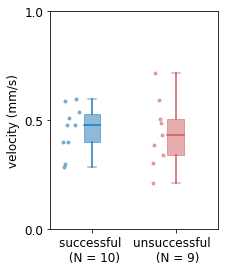

In [5]:
font = {'family' : 'roboto',
        'weight' : 'normal',
        'size'   : 12}
import matplotlib as mpl
mpl.rc('font', **font)
f, ax = plt.subplots(1,1, figsize=(3,4))
_, x, vc = control.plot(ax, keys = 'velocity', metric='mean', plot_type='box');
random.color='#cd5c5cff'
_, x,vr = random.plot(ax, keys = 'velocity', metric='mean', plot_type='box', loc=0.5);
# test
print(stats.mannwhitneyu(vc, vr, use_continuity=True, alternative='two-sided'))
ax.set_xticks([0,0.5])
ax.set_xticklabels([f'successful \n (N = {len(control)})', f'unsuccessful  \n (N = {len(random)})'])
plt.setp(ax, ylabel = 'velocity (mm/s)', yticks=[0, 0.5, 1.0], xlim=(-0.25, 0.75));
#plt.savefig('Larvae_velocity.svg')

MannwhitneyuResult(statistic=52.0, pvalue=0.5956108994757296)


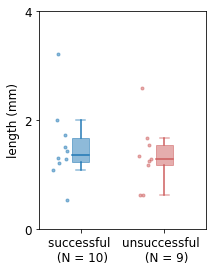

In [42]:
f, ax = plt.subplots(1,1, figsize=(3,4))
_, x, vc = control.plot(ax, keys = 'length', metric='mean', plot_type='box');
random.color='#cd5c5cff'
_, x,vr = random.plot(ax, keys = 'length', metric='mean', plot_type='box', loc=0.5);
# test
print(stats.mannwhitneyu(vc, vr, use_continuity=True, alternative='two-sided'))
ax.set_xticks([0,0.5])
ax.set_xticklabels([f'successful \n (N = {len(control)})', f'unsuccessful  \n (N = {len(random)})'])
plt.setp(ax, ylabel = 'length (mm)', yticks=[0,2,4], xlim=(-0.25, 0.75));
#plt.savefig('Larvae_length.svg')

successful:  0.09232213559090395 0.393376448371231
unsuccessful:  0.8083761458009138 0.0009723066699837358


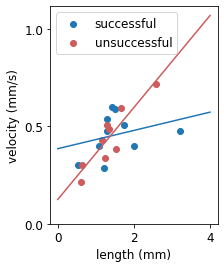

In [111]:
f, ax = plt.subplots(1,1, figsize=(3,4))
_, lc, vc = control.plot(ax, keys = ['length', 'velocity'], metric='mean', plot_type='scatter', label='successful');
_, lr, vr = random.plot(ax, keys = ['length', 'velocity'], metric='mean', plot_type='scatter', label='unsuccessful');
plt.legend()

slope, intercept, r_value, p_value, std_err = stats.linregress(lc, vc)
print('successful: ', r_value**2, p_value)
ax.plot(np.arange(5), slope*np.arange(5)+intercept)

slope, intercept, r_value, p_value, std_err = stats.linregress(lr, vr)
print('unsuccessful: ',r_value**2, p_value)
ax.plot(np.arange(5), slope*np.arange(5)+intercept, color=random.color)

plt.setp(ax, xlabel = 'length (mm)',  ylabel = 'velocity (mm/s)', yticks=[0,0.5,1.0], xticks=[0,2,4], );
#plt.savefig('Larvae_correlation_l_v.svg')

/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:1001: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:1001: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')


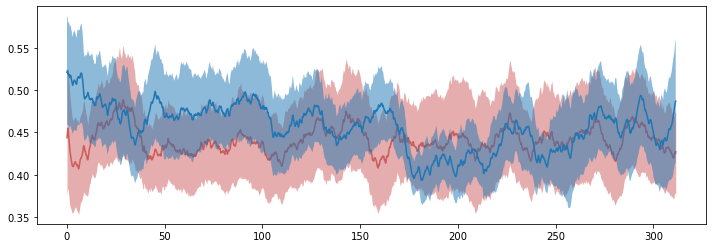

In [151]:
f, ax = plt.subplots(1,1, figsize=(12,4))
_, lc, vc = control.plot(ax, keys = ['time', 'velocity_smooth'], metric=None,metric_sample='mean', metric_error='sem', plot_type='line', label='successful');
_, lr, vr = random.plot(ax, keys = ['time', 'velocity_smooth'], metric=None,metric_sample='mean',metric_error='sem', plot_type='line', label='successful', zorder=-1);

/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:1001: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')
/gpfs/soma_fs/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:1001: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')


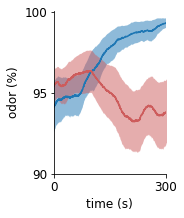

In [928]:
f, ax = plt.subplots(1,1, figsize=(2.0,3.0))
_, lc, vc = control.plot(ax, keys = ['time', 'odor'], metric=None,metric_sample='mean', metric_error='sem', plot_type='line', label='successful');
_, lc, vc = random.plot(ax, keys = ['time', 'odor'], metric=None,metric_sample='mean', metric_error='sem', plot_type='line', label='successful');
# individuals
# _, lc, vc = random.plot(plt.gca(), keys = ['time', 'odor'], metric=None,metric_sample=None, metric_error='sem', plot_type='line', label='successful',  alpha=0.2, zorder=-3);
# _, lc, vc = control.plot(plt.gca(), keys = ['time', 'odor'], metric=None,metric_sample=None, metric_error='sem', plot_type='line', label='successful', color='C0', alpha=0.2, zorder=-3);
plt.setp(ax, xlabel = 'time (s)',  ylabel = 'odor (%)', yticks=(90,95,100), xticks=(0,300), xlim=(0,300));
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('Larvae_odor.svg')

## Save as pickle


In [47]:
control.dump('Larvae_successful')
random.dump('Larvae_unsuccessful')

In [3]:
# load from pickle
control = pga.Experiment.load('Larvae_successful')
random = pga.Experiment.load('Larvae_unsuccessful')

## Dimensionality of motion

In [4]:
# head-tail flips
heads_control = [1,1,1,-1,1,1,-1,1,1,-1]
heads_random = [1,1,1,1,-1,1,1,-1,1]

In [5]:
# optimize alpha ratio
from scipy.optimize import minimize_scalar
def fun(a,r,g, center = 150, width = 30):
    return np.sum(g[:,center-width:center+width]-a*r[:,center-width:center+width])**2

def estimate_ratioalpha(r,g, width = 40):
    center= g.shape[2]//2

    alphas = []
    for i in range(0,len(g), 30):
        res = minimize_scalar(fun, bracket = (0,1), args = (r[i], g[i], center, width))
        alphas.append(res.x)
    # turns out using the mean image is about the same:
    res = minimize_scalar(fun, bracket = (0,1), args = (np.mean(r,axis=0), np.mean(g,axis=0), center, width))
    alpha = res.x
    return alpha

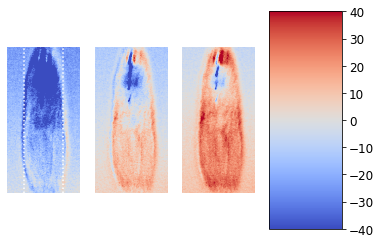

In [1443]:
sample = control.samples[0]
r = sample.straight_red[:,::heads_control[0]]
g = sample.straight_green[:,::heads_control[0]]
# xample ratio correction
alpha = estimate_ratioalpha(r,g, width = 40)
plt.subplot(141)
plt.imshow(g[0]-1.5*alpha*r[0],vmin=-40, vmax=40, cmap='coolwarm')
plt.gca().axis('off')
plt.axvline(center-width, linestyle=':', color='w')
plt.axvline(center+width,linestyle=':', color='w')
plt.subplot(142)
plt.imshow(g[0]-alpha*r[0],vmin=-40, vmax=40, cmap='coolwarm')
plt.gca().axis('off')
plt.subplot(143)
plt.imshow(g[0]-0.75*alpha*r[0], vmin=-40, vmax=40, cmap='coolwarm')
plt.gca().axis('off')
ax = plt.subplot(144)
plt.colorbar(cax = ax, shrink=0.2)
plt.savefig('Example_ratiocorrection.svg')

In [240]:
# get features out. First we use the ratiometric correction, then 

In [8]:
def leftrightflip(images):
    """we do not disciminate left and right correctly so here we flip into the same orientation."""
    sample = images[0]
    tmp = []
    for current in images:
        if np.mean((sample-current)**2) > np.mean((sample-current[:,::-1])**2):
            current = current[:,::-1]
        tmp.append(current)
        sample = current
    return np.array(tmp)

## Correlate behavior with calcium

### For unsuccessful tracks

In [147]:
# Using engineered features
from skimage.util import view_as_blocks
# prepare data - orient all heads, extract all features in red and green channels
engineered = {}
fps = 19.6
for sidx, sample in enumerate(random.samples[:1]):
    r = sample.straight_red[:,::heads_random[sidx]]
    g = sample.straight_green[:,::heads_random[sidx]]
    # estimate correction
    alpha = estimate_ratioalpha(r,g, width = 40)
    # ratiometric
    ratio = g - alpha*r 
    ratio -= np.mean (ratio, axis=0)
    engineered[sidx] = pd.DataFrame()
    # calculate features
    N = len(sample.data)
    # fix left-right correspondence
    ratio = leftrightflip(ratio)
    # extract features
    center = ratio.shape[2]//2
    width = 60
    head = 40
    data = ratio[:, :, center-width:center+width]
    # left-right side
    left = np.mean(data[:,head:,:width], axis=(1,2))
    right = np.mean(data[:,head:,width:], axis=(1,2))
    asymmetry = left - right
    total_activity = np.mean(data, axis=(1,2))
    # A-P axis
    kymo = savgol_filter(np.max(ratio, axis=2), window_length=55, polyorder=2, deriv=0, delta=1.0, axis=1, mode='interp', cval=0.0)
    #smoothed = savgol_filter(smoothed, window_length=7, polyorder=2, deriv=0, delta=1.0, axis=0, mode='interp', cval=0.0)
    #baseline = np.mean(smoothed, axis=0)
    #kymo -= baseline
    #kymo /= baseline
    headI = np.mean(kymo[:, :head], axis=1)
    anteriorI = np.mean(kymo[:,head:head+80], axis=1)
    middleI = np.mean(kymo[:,head+80:head+2*80], axis=1)
    tailI = np.mean(kymo[:,head+2*80:], axis=1)
    #peak_location = np.argmax(kymo[:,head:-10], axis=1)
    #peak_intensity = np.max(kymo, axis=1)
    # store in name
    #L-R features
    engineered_random[sidx] = pd.DataFrame()
    engineered_random[sidx][f'left'] = np.pad(left, (0, N-len(left)), mode='mean')
    engineered_random[sidx][f'right'] = np.pad(right, (0, N-len(left)), mode='mean')
    engineered_random[sidx][f'asymmetry'] = np.pad(asymmetry, (0, N-len(asymmetry)), mode='mean')
    engineered_random[sidx][f'total_activity'] = np.pad(total_activity, (0, N-len(total_activity)), mode='mean')
    # AP features
    engineered_random[sidx][f'headI'] = np.pad(headI, (0, N-len(headI)), mode='mean')
    engineered_random[sidx][f'anteriorI'] = np.pad(anteriorI, (0, N-len(headI)), mode='mean')
    engineered_random[sidx][f'middleI'] = np.pad(middleI, (0, N-len(middleI)), mode='mean')
    engineered_random[sidx][f'tailI'] = np.pad(tailI, (0, N-len(tailI)), mode='mean')
    # track
    engineered_random[sidx]['x_spot'] = sample.data.x_spot
    engineered_random[sidx]['y_spot'] = sample.data.y_spot
    engineered_random[sidx]['odor'] = sample.data.odor
    engineered_random[sidx]['Deltaodor'] = savgol_filter(sample.data.odor, window_length=101, polyorder = 2, deriv=1)
    engineered_random[sidx]['velocity'] = sample.data.velocity_smooth
    engineered_random[sidx]['time'] = sample.data.index/fps
    # behaviors
    animal_size = 0.5
    angle_threshold = 100
    # Calculate the distance cover by the centroid of the worm between two frames um
    distance = np.cumsum(sample.data.velocity)* engineered_random[sidx]['time'].diff()
    # find the maximum number of worm lengths we have travelled
    maxlen = distance.max()/animal_size
    # make list of levels that are multiples of animal size
    levels = np.arange(animal_size, maxlen*animal_size, animal_size)
    # Find the indices where the distance is equal or the closest to the pixel interval by repeatedly subtracting the levels
    indices = []
    for level in levels:
        idx = distance.sub(level).abs().idxmin()
        indices.append(idx)
    # create a downsampled trajectory from these indices
    traj_Resampled =  engineered_random[sidx].loc[indices, ['x_spot', 'y_spot']].diff()
    # we ignore the index here for the shifted data
    traj_Resampled[['x1', 'y1']] = traj_Resampled.shift(1).fillna(0)
    # use the dot product to calculate the andle
    def angle(row):
        v1 = [row.x_spot, row.y_spot]
        v2 = [row.x1, row.y1]
        return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
    traj_Resampled['angle'] = 0
    traj_Resampled['angle']= traj_Resampled.apply(lambda row: angle(row), axis =1)
    rev = traj_Resampled.index[traj_Resampled.angle>=angle_threshold]
    engineered_random[sidx].loc[:,'reversals'] = 0
    engineered_random[sidx].loc[rev,'reversals'] = 1

/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars


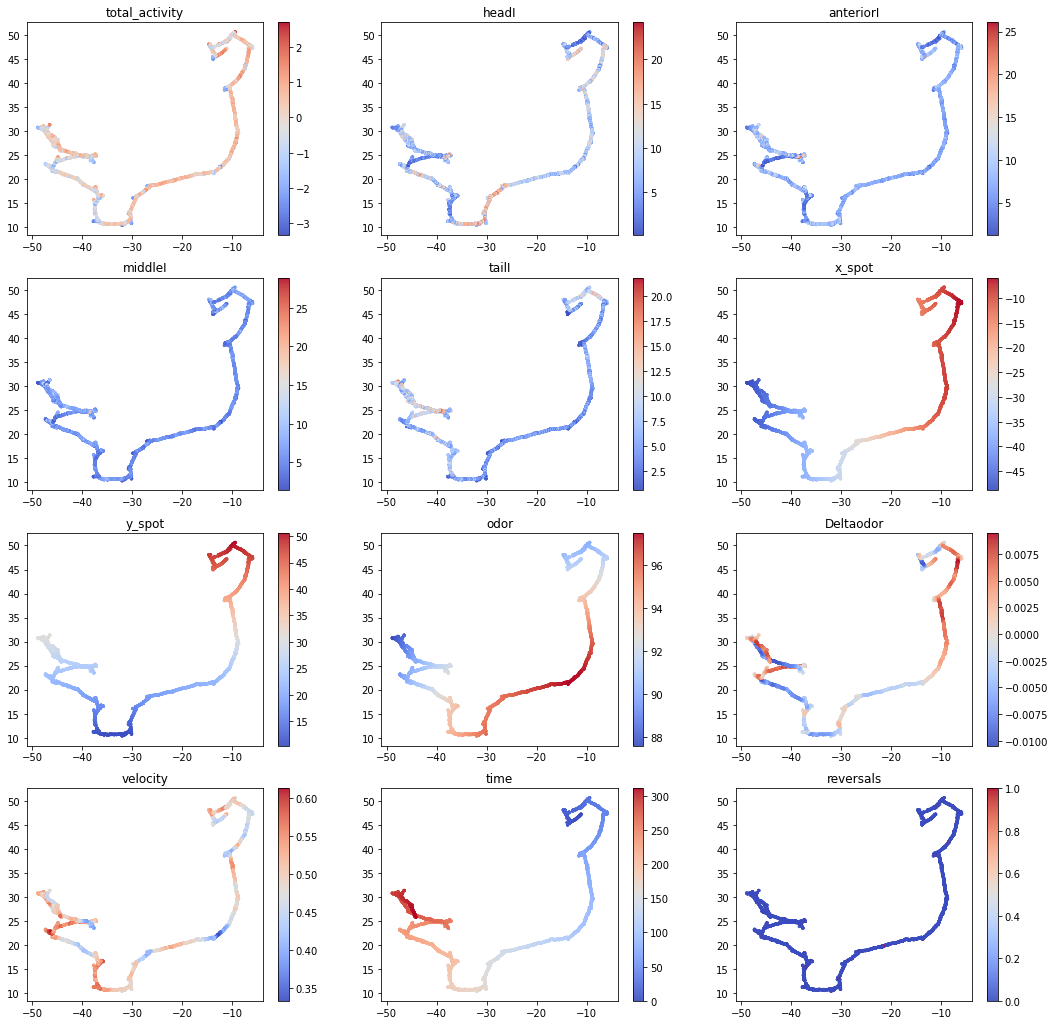

In [148]:
f, axes = plt.subplots(4,3, figsize=(18,18))
axes = axes.ravel()
df = engineered_random[0]
for ci, col in enumerate(df.columns[3:]):
    im = axes[ci].scatter(df['x_spot'], df['y_spot'], alpha=0.9, s=5, c=df[col], cmap='coolwarm')
    axes[ci].set_title(col)
    plt.colorbar(im, ax = axes[ci])

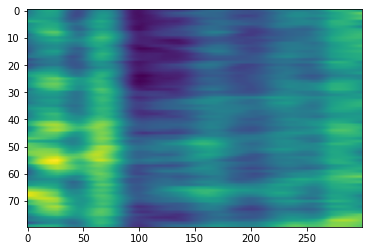

In [193]:
tmp = [kymo[tau-40:tau+40] for tau in np.where(df['reversals']==1)[0] if tau+120<len(kymo)]
plt.imshow(np.mean(tmp,axis=0),aspect='auto')

In [151]:
df = pd.concat(dset for _,dset in engineered_random.items())

In [152]:
df.to_csv('UnsuccessfulTracks.csv')

Text(0.5, 0, 'PC3')

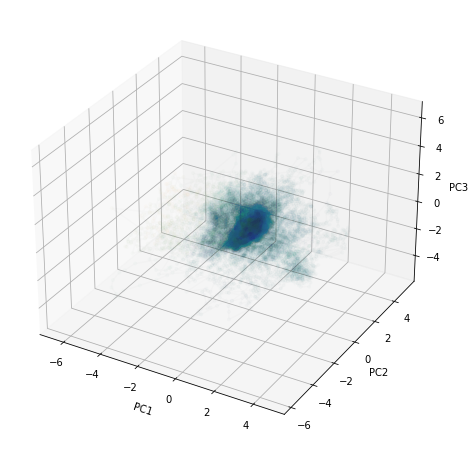

In [153]:
from sklearn.decomposition import PCA

# Assuming data is a 3D numpy array of shape (10, 6105, 300)
# Reshape data to 2D array of shape (10*6105, 300)

data = df.values[:,:4]

# Initialize PCA
pca = PCA(n_components=3, whiten=True)  # Change n_components to the number of principal components you want

# Fit and transform the data to the first two principal components
projection = pca.fit_transform(data)

principalComponents = pca.components_

c1 = 0
c2 =1
c3 = 2
t_start = 0
t_end = t_start + 50000
colordata = df['Deltaodor']
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection='3d')
ax.scatter(projection[t_start:t_end,c1], projection[t_start:t_end,c2],projection[t_start:t_end,c3], s = 10*np.ones((t_end-t_start)), alpha=0.01, c=colordata[t_start:t_end])
#plt.scatter(projection[t_start:t_end,c1], projection[t_start:t_end,c2], alpha=0.1, s=50, c=velo[t_start:t_end])
plt.plot(projection[t_start:t_end,c1], projection[t_start:t_end,c2],  projection[t_start:t_end,c3], alpha=0.01, zorder=-1, color='k')#, c=np.arange(projection.shape[0]))

plt.xlabel(f'PC${c1+1}$')
plt.ylabel(f'PC{c2+1}')
ax.set_zlabel(f'PC{c3+1}')

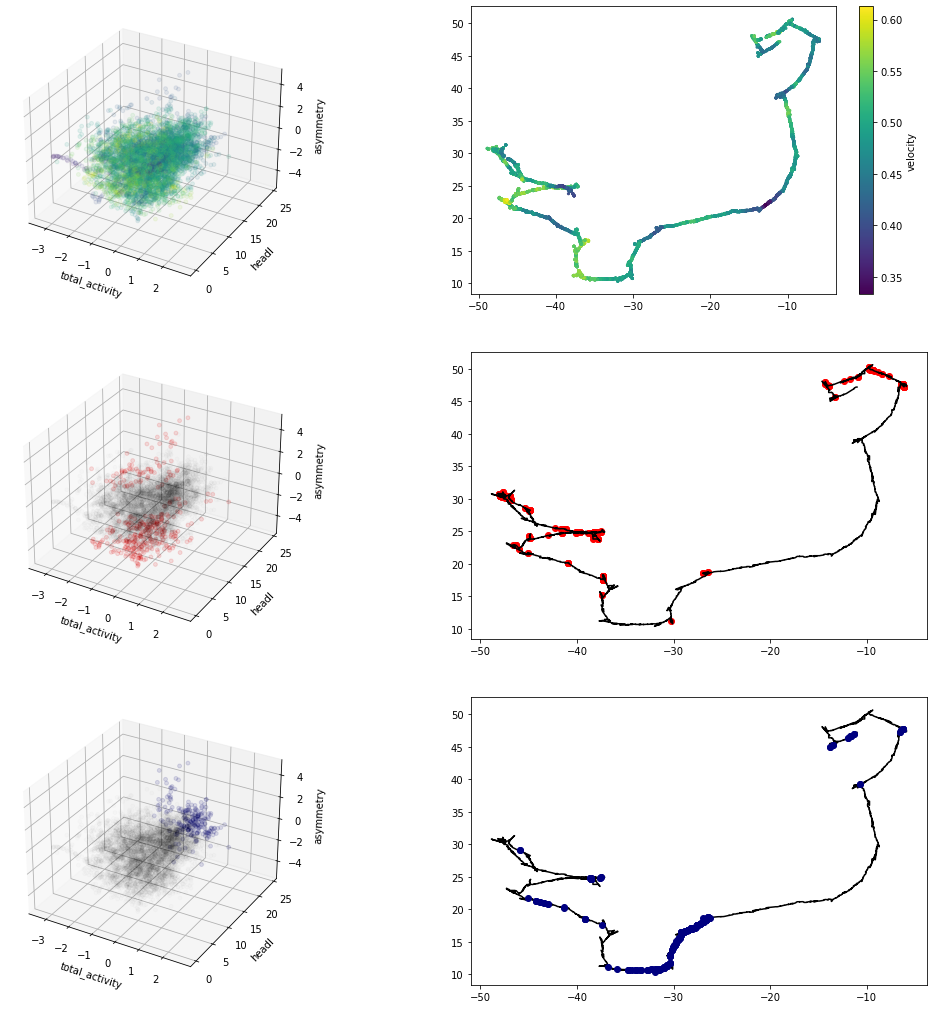

In [154]:
plt.figure(figsize=(18,18), facecolor='white')
i=0
t_start = 6105*i
t_end = t_start+6105

key1 = 'total_activity'
key3 = 'asymmetry'
key2 = 'headI'
p1 = df[key1].values
p2 = df[key2].values
p3 = df[key3].values
colorkey = 'velocity'
colordata = df[colorkey].values

ax = plt.subplot(3,2,1, projection='3d')
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.1,c=colordata[t_start:t_end])

plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')
ax = plt.subplot(3,2,2)
plt.scatter(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], c= colordata[t_start:t_end], cmap='viridis', s=5)
plt.colorbar(label=colorkey)

# turns 
ax = plt.subplot(3,2,3, projection='3d')
turns = np.where(df.iloc[t_start:t_end]['asymmetry'].abs()>(df.iloc[t_start:t_end]['asymmetry'].mean()+2.0*df.iloc[t_start:t_end]['asymmetry'].std()))
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.01, c='k')
ax.scatter(p1[turns], p2[turns],p3[turns], s = 15*np.ones((len(turns))), alpha=0.1, c='r')
plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')

ax = plt.subplot(3,2,4)
plt.plot(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], color = 'k')
plt.scatter(df.iloc[t_start:t_end]['x_spot'].values[turns], df.iloc[t_start:t_end]['y_spot'].values[turns], color = 'r')

# head 
# turns 
ax = plt.subplot(3,2,5, projection='3d')
headcast = np.where(df.iloc[t_start:t_end]['headI']>(df.iloc[t_start:t_end]['headI'].mean()+2.0*df.iloc[t_start:t_end]['headI'].std()))
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.01, c='k')
ax.scatter(p1[headcast], p2[headcast],p3[headcast], s = 15*np.ones((len(headcast))), alpha=0.1, c='navy')
plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')

ax = plt.subplot(3,2,6)
plt.plot(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], color = 'k', zorder=-1)
plt.scatter(df.iloc[t_start:t_end]['x_spot'].values[headcast], df.iloc[t_start:t_end]['y_spot'].values[headcast], color = 'navy')
plt.savefig('DimReduction_random.png', dpi=300)

# For successful tracks

In [2416]:
# Using engineered features
from skimage.util import view_as_blocks
# prepare data - orient all heads, extract all features in red and green channels
engineered = {}
for sidx, sample in enumerate(control.samples[:]):
    r = sample.straight_red[:,::heads_control[sidx]]
    g = sample.straight_green[:,::heads_control[sidx]]
    # estimate correction
    alpha = estimate_ratioalpha(r,g, width = 40)
    # ratiometric
    ratio = g - alpha*r 
    ratio -= np.mean (ratio, axis=0)
    engineered[sidx] = pd.DataFrame()
    # calculate features
    N = len(sample.data)
    # fix left-right correspondence
    ratio = leftrightflip(ratio)
    # extract features
    center = ratio.shape[2]//2
    width = 60
    head = 40
    data = ratio[:, :, center-width:center+width]
    # left-right side
    left = np.mean(data[:,head:,:width], axis=(1,2))
    right = np.mean(data[:,head:,width:], axis=(1,2))
    asymmetry = left - right
    total_activity = np.mean(data, axis=(1,2))
    # A-P axis
    kymo = savgol_filter(np.max(ratio, axis=2), window_length=55, polyorder=2, deriv=0, delta=1.0, axis=1, mode='interp', cval=0.0)
    #smoothed = savgol_filter(smoothed, window_length=7, polyorder=2, deriv=0, delta=1.0, axis=0, mode='interp', cval=0.0)
    #baseline = np.mean(smoothed, axis=0)
    #kymo -= baseline
    #kymo /= baseline
    headI = np.mean(kymo[:, :head], axis=1)
    anteriorI = np.mean(kymo[:,head:head+80], axis=1)
    middleI = np.mean(kymo[:,head+80:head+2*80], axis=1)
    tailI = np.mean(kymo[:,head+2*80:], axis=1)
    #peak_location = np.argmax(kymo[:,head:-10], axis=1)
    #peak_intensity = np.max(kymo, axis=1)
    # store in name
    #L-R features
    engineered[sidx] = pd.DataFrame()
    engineered[sidx][f'left'] = np.pad(left, (0, N-len(left)), mode='mean')
    engineered[sidx][f'right'] = np.pad(right, (0, N-len(left)), mode='mean')
    engineered[sidx][f'asymmetry'] = np.pad(asymmetry, (0, N-len(asymmetry)), mode='mean')
    engineered[sidx][f'total_activity'] = np.pad(total_activity, (0, N-len(total_activity)), mode='mean')
    # AP features
    engineered[sidx][f'headI'] = np.pad(headI, (0, N-len(headI)), mode='mean')
    engineered[sidx][f'anteriorI'] = np.pad(anteriorI, (0, N-len(headI)), mode='mean')
    engineered[sidx][f'middleI'] = np.pad(middleI, (0, N-len(middleI)), mode='mean')
    engineered[sidx][f'tailI'] = np.pad(tailI, (0, N-len(tailI)), mode='mean')
    # track
    
    engineered[sidx]['x_spot'] = sample.data.x_spot
    engineered[sidx]['y_spot'] = sample.data.y_spot
    engineered[sidx]['odor'] = sample.data.odor
    engineered[sidx]['Deltaodor'] = savgol_filter(sample.data.odor, window_length=101, polyorder = 2, deriv=1)
    engineered[sidx]['velocity'] = sample.data.velocity_smooth

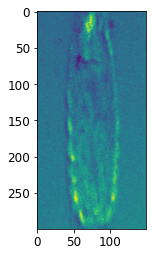

In [2417]:
plt.imshow(ratio[2400])

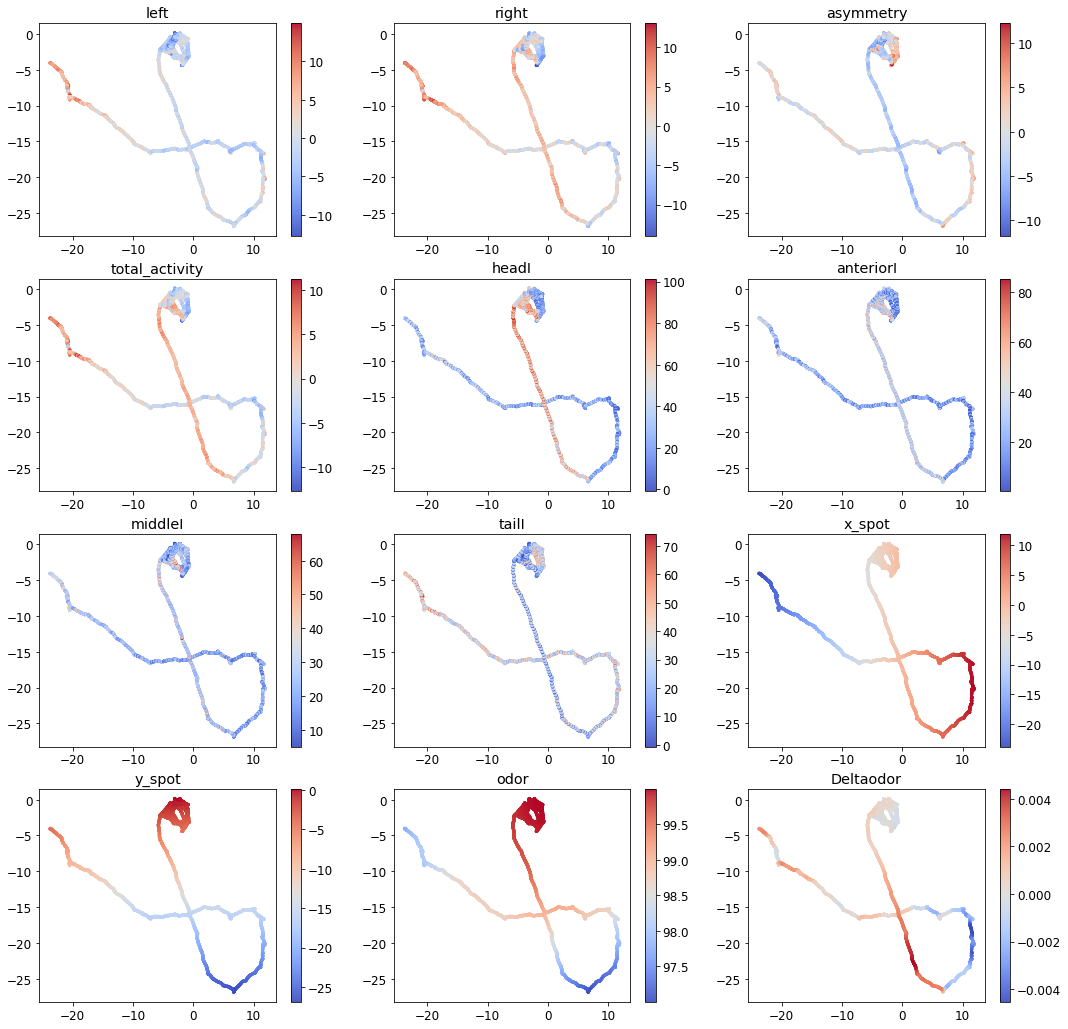

In [2418]:
f, axes = plt.subplots(4,3, figsize=(18,18))
axes = axes.ravel()
df = engineered[2]
for ci, col in enumerate(df.columns[:12]):
    im = axes[ci].scatter(df['x_spot'], df['y_spot'], alpha=0.9, s=5, c=df[col], cmap='coolwarm')
    axes[ci].set_title(col)
    plt.colorbar(im, ax = axes[ci])
#plt.colorbar()
#plt.xlim(0, 6000)

In [2419]:
df = pd.concat(dset for _,dset in engineered.items())

In [2420]:
df

,left,right,asymmetry,total_activity,headI,anteriorI,middleI,tailI,x_spot,y_spot,odor,Deltaodor,velocity
0,2.834081,4.863043,-2.028962,2.348485,16.510205,13.859416,27.273590,21.772152,-35.328289,5.645306,95.047638,-0.001350,0.629249
1,4.126448,6.206827,-2.080379,3.803794,33.220641,21.785696,26.367454,23.335471,-35.328289,5.645306,95.047638,-0.001237,0.628340
2,4.146580,6.154997,-2.008417,3.743001,31.410993,25.234458,27.191540,25.531443,-35.328289,5.645306,95.047638,-0.001123,0.627448
3,3.613350,5.604393,-1.991044,3.224726,28.507758,26.559610,26.797739,26.551182,-35.514769,5.798232,94.991227,-0.001009,0.626574
4,2.790012,4.867780,-2.077769,2.137582,16.877198,23.395604,23.894625,24.846645,-35.514769,5.798232,94.991227,-0.000896,0.625717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,-4.244892,-0.222803,-4.022089,-1.702313,45.530759,28.493804,12.833799,12.415489,-0.771636,0.369053,99.997097,-0.000058,0.264487
6101,-4.561901,0.524257,-5.086158,-1.461134,42.996258,34.162488,15.364807,12.954452,-0.771636,0.369053,99.997097,-0.000061,0.262930
6102,-4.950160,1.035710,-5.985870,-1.317794,44.070645,37.657666,17.017275,12.824267,-0.771636,0.369053,99.997097,-0.000064,0.261337
6103,-5.168189,0.901980,-6.070170,-1.748703,40.078800,38.618596,17.641279,13.277465,-0.797975,0.325077,99.997054,-0.000067,0.259647


In [2423]:
df.to_csv('SuccessfulTracks.csv')

Text(0.5, 0, 'PC3')

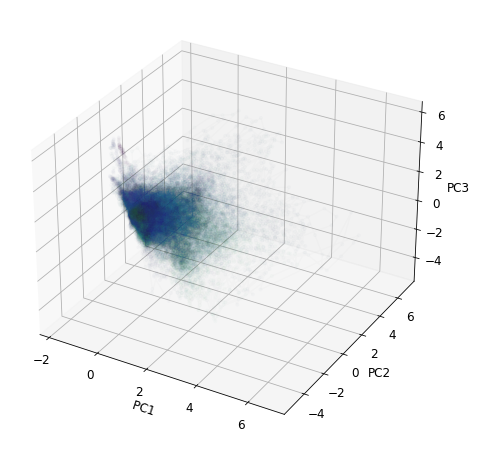

In [2421]:
from sklearn.decomposition import PCA

# Assuming data is a 3D numpy array of shape (10, 6105, 300)
# Reshape data to 2D array of shape (10*6105, 300)

data = df.values[:,:6]

# Initialize PCA
pca = PCA(n_components=3, whiten=True)  # Change n_components to the number of principal components you want

# Fit and transform the data to the first two principal components
projection = pca.fit_transform(data)

principalComponents = pca.components_

c1 = 0
c2 =1
c3 = 2
t_start = 0
t_end = t_start + 60000

colordata = df['velocity']
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection='3d')
ax.scatter(projection[t_start:t_end,c1], projection[t_start:t_end,c2],projection[t_start:t_end,c3], s = 10*np.ones((t_end-t_start)), alpha=0.01, c=colordata[t_start:t_end])
#plt.scatter(projection[t_start:t_end,c1], projection[t_start:t_end,c2], alpha=0.1, s=50, c=velo[t_start:t_end])
plt.plot(projection[t_start:t_end,c1], projection[t_start:t_end,c2],  projection[t_start:t_end,c3], alpha=0.01, zorder=-1, color='k')#, c=np.arange(projection.shape[0]))

plt.xlabel(f'PC${c1+1}$')
plt.ylabel(f'PC{c2+1}')
ax.set_zlabel(f'PC{c3+1}')

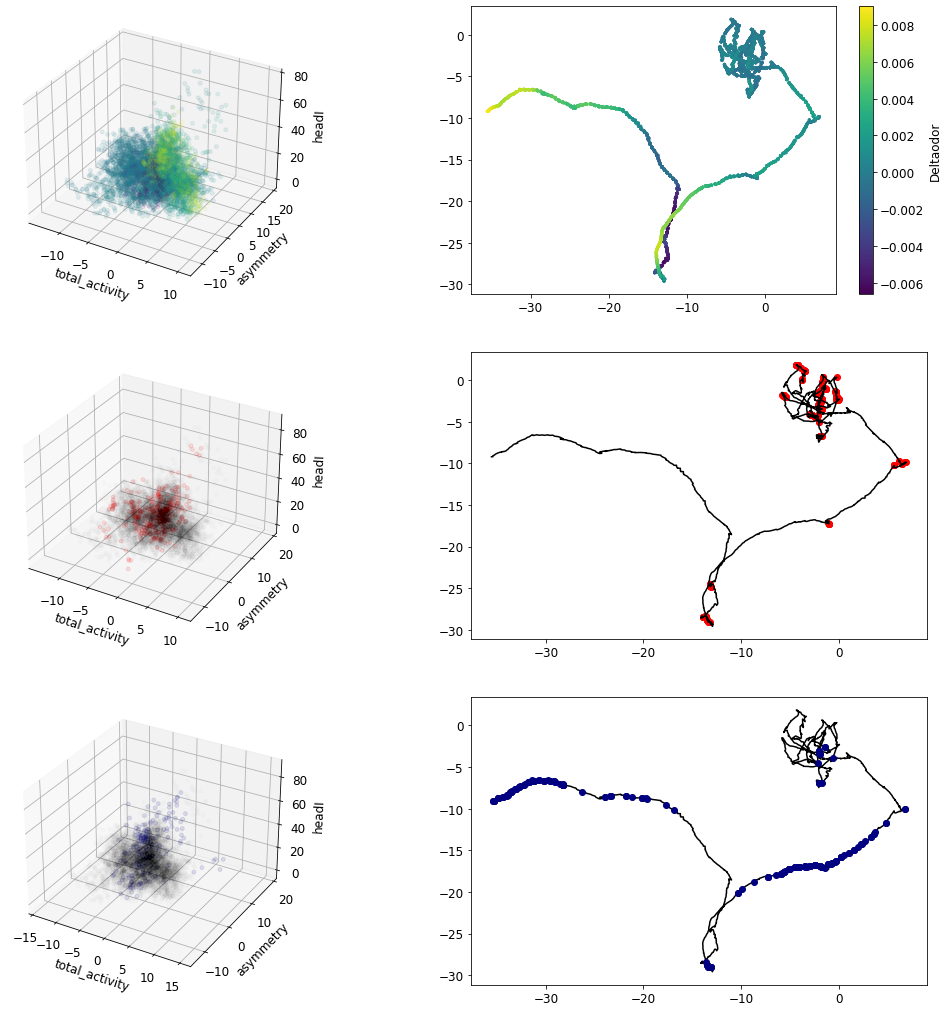

In [2422]:
plt.figure(figsize=(18,18), facecolor='white')
i=7
t_start = 6105*i
t_end = t_start+6105

key1 = 'total_activity'
key2 = 'asymmetry'
key3 = 'headI'
p1 = df[key1].values
p2 = df[key2].values
p3 = df[key3].values
colorkey = 'Deltaodor'
colordata = df[colorkey].values

ax = plt.subplot(3,2,1, projection='3d')
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.1,c=colordata[t_start:t_end])

plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')
ax = plt.subplot(3,2,2)
plt.scatter(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], c= colordata[t_start:t_end], cmap='viridis', s=5)
plt.colorbar(label=colorkey)

# turns 
ax = plt.subplot(3,2,3, projection='3d')
turns = np.where(df.iloc[t_start:t_end]['asymmetry'].abs()>(df.iloc[t_start:t_end]['asymmetry'].mean()+2.0*df.iloc[t_start:t_end]['asymmetry'].std()))
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.01, c='k')
ax.scatter(p1[turns], p2[turns],p3[turns], s = 15*np.ones((len(turns))), alpha=0.1, c='r')
plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')

ax = plt.subplot(3,2,4)
plt.plot(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], color = 'k')
plt.scatter(df.iloc[t_start:t_end]['x_spot'].values[turns], df.iloc[t_start:t_end]['y_spot'].values[turns], color = 'r')

# head 
# turns 
ax = plt.subplot(3,2,5, projection='3d')
headcast = np.where(df.iloc[t_start:t_end]['headI']>(df.iloc[t_start:t_end]['headI'].mean()+2.0*df.iloc[t_start:t_end]['headI'].std()))
ax.scatter(p1[t_start:t_end], p2[t_start:t_end],p3[t_start:t_end], s = 15*np.ones((t_end-t_start)), alpha=0.01, c='k')
ax.scatter(p1[headcast], p2[headcast],p3[headcast], s = 15*np.ones((len(headcast))), alpha=0.1, c='navy')
plt.xlabel(f'{key1}')
plt.ylabel(f'{key2}')
ax.set_zlabel(f'{key3}')

ax = plt.subplot(3,2,6)
plt.plot(df.iloc[t_start:t_end]['x_spot'], df.iloc[t_start:t_end]['y_spot'], color = 'k', zorder=-1)
plt.scatter(df.iloc[t_start:t_end]['x_spot'].values[headcast], df.iloc[t_start:t_end]['y_spot'].values[headcast], color = 'navy')
plt.savefig('DimReduction_control.png', dpi=300)

In [ ]:
# plt.sc

In [2400]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
def move_axes(ax, action, step):
    if action == 'left':
        pos = ax.get_position().get_points()
        pos[:, 0] -= step
    if action == 'right':
        pos = ax.get_position().get_points()
        pos[:, 0] += step
    if action == 'down':
        pos = ax.get_position().get_points()
        pos[:, 1] -= step
    if action == 'up':
        pos = ax.get_position().get_points()
        pos[:, 1] += step
    if action == 'scale':
        pos = ax.get_position().get_points()
        pos[1, :] += step/2.
        pos[0, :] -= step/2.
    if action == 'scaley':
        pos = ax.get_position().get_points()
        pos[1, 1] += step/2.
        pos[0, 1] -= step/2.
    if action == 'scalex':
        pos = ax.get_position().get_points()
        pos[1, 0] += step/2.
        pos[0, 0] -= step/2.
    pos_new = mpl.transforms.Bbox(pos)
    ax.set_position(pos_new)


def color_coded_plot(x, y, axis, t=None):
    if t is None:
        t = np.arange(0, x.shape[0])
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(t.min(), t.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(t)
    lc.set_linewidth(2)
    line = axis.add_collection(lc)
    axis.set_xlim(np.min(x), np.max(x))
    axis.set_ylim(np.min(y), np.max(y))
    return line
    # Use a boundary norm instead
    # cmap = ListedColormap(['r', 'g', 'b'])
    # norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
    # lc = LineCollection(segments, cmap=cmap, norm=norm)
    # lc.set_array(t)
    # lc.set_linewidth(2)
    # line = axs[1].add_collection(lc)
    # fig.colorbar(line, ax=axs[1])
    #
    # axs[0].set_xlim(x.min(), x.max())
    # axs[0].set_ylim(-1.1, 1.1)
    # plt.show()

def derivative(y, x=None):
    # TODO: replace with https://github.com/florisvb/PyNumDiff  then cite as requested
    if x is None:
        x = range(0, y.size)
    #dy = np.diff(y, axis=0)
    dy = np.zeros(y.shape)
    if len(y.shape) == 2:
        dy[0, :] = (y[1, :] - y[0, :])/(x[1] - x[0])
        for index in range(1, y.shape[0]-1):
            d_left = (y[index+1, :] - y[index, :])/(x[index+1] - x[index])
            d_right = (y[index, :] - y[index-1, :])/(x[index] - x[index-1])
            dy[index, :] = (d_left + d_right)/2
    else:
        dy[0] = (y[1] - y[0]) / (x[1] - x[0])
        for index in range(1, y.shape[0] - 1):
            d_left = (y[index + 1] - y[index]) / (x[index + 1] - x[index])
            d_right = (y[index] - y[index - 1]) / (x[index] - x[index - 1])
            dy[index] = (d_left + d_right) / 2
    return dy


def color_coded_plot3D(x, y, z, axis, t=None):
    if t is None:
        t = np.arange(0, x.shape[0])
    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 3 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 3 (for x, y, and z)
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(t.min(), t.max())
    lc = Line3DCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(t)
    lc.set_linewidth(2)
    line = axis.add_collection3d(lc)
    axis.set_xlim(np.min(x), np.max(x))
    axis.set_ylim(np.min(y), np.max(y))
    axis.set_zlim(np.min(z), np.max(z))
    return line

def principal_components_analysis(signal, sampling_rate, folder, columns = []):
    #%%
    location = str(folder).find('set')  # Used to label figures according to the experimental group
    time = np.arange(0, signal.shape[0]/sampling_rate, 1/sampling_rate)
    print("Dataset has {} time points and features {} neurons".format(*signal.shape))
    pca = PCA(n_components=5)

    #pcs = np.cumsum(pca.fit_transform(savgol_filter(signal, axis=0, window_length=11, polyorder=1, deriv=1)), axis=0)  # principal components.
    pcs = pca.fit_transform(signal)
    # cumsum is to integrate back the derivative
    weights = pca.components_
    # sort the weights by the first component, so that all positive, then all negative from large to small appear
    pcorder = np.argsort(weights[0])
    loc = np.where(weights[0][pcorder] < 0)[0][-1]
    pcorder = np.hstack([pcorder[:loc][::-1], pcorder[loc:][::-1]])

    #%%
    fig = plt.figure(figsize=(12, 8))
    gsHeatmap = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 0.75], width_ratios=[2, 1, 1], hspace=0.25, wspace=0.25)
    # heatmap of calcium
    axhm = plt.subplot(gsHeatmap[0, 0])
    hm = axhm.imshow(signal.T[pcorder]/np.max(signal.T[pcorder], axis=0), vmin=-1.5, vmax=1, aspect='auto')
    plt.setp(axhm, ylabel='Features', xlabel='', xlim=(0, signal.shape[0]), ylim=(0, signal.shape[1]))
    time_step = 100*sampling_rate
    ticks = np.arange(0, signal.shape[0]+1, time_step)
    ticklabels = ["{:6.0f}".format(i) for i in ticks/sampling_rate]
    axhm.set_xticks(ticks)
    axhm.set_xticklabels(ticklabels)
    axhm.set_yticks(np.arange(signal.shape[1]))
    axhm.set_yticklabels(columns)
    # colorbar
    axcb = plt.subplot(gsHeatmap[1, 0])
    fig.colorbar(hm, cax=axcb, orientation='horizontal', label='$\Delta F/F_0$')
    # PCA weights axis
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gsHeatmap[0, 1])
    axweights = [plt.subplot(gs00[i], sharey=axhm) for i in range(3)]
    [axweights[i].fill_betweenx(np.arange(signal.shape[1]), weights[i][pcorder], step='pre', color=f'C{i}',
                                clip_on=False) for i in range(3)]
    #[plt.setp(ax, yticks =[], xticks=[], xlim=(-0.3, 0.3)) for ax in axweights]
    axweights[1].set_xlabel('PCA weights')

    #scale bar for weights
    scale = 0.4
    scalebar = [-0.55, -0.55+scale]
    axweights[0].plot(scalebar, [0, 0], lw=3, clip_on=False)
    axweights[0].text(np.mean(scalebar), 3, f'{scale}', ha='center')

    # show transformed data
    gs10 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gsHeatmap[2, 0])
    axPCs = [plt.subplot(gs10[i]) for i in range(3)]  #
    [axPCs[i].plot(time, pcs[:, i], label=f'PC_{i+1}') for i in range(3)]
    plt.setp(axPCs[0], ylabel='PC1')
    axPCs[0].get_xaxis().set_ticks([])
    plt.setp(axPCs[1], ylabel='PC2')
    axPCs[1].get_xaxis().set_ticks([])
    plt.setp(axPCs[2], ylabel='PC3', xlabel='Time (s)')

    # explained variance
    axVar = plt.subplot(gsHeatmap[2, 1])
    axVar.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
               np.cumsum(pca.explained_variance_ratio_)*100, color='k', marker='o')
    plt.setp(axVar, ylabel='% variance explained', xlabel='# components')

    # phase plots showing manifolds (sub-volume in PCA space occupied by the neural state trajectory)
    gs20 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gsHeatmap[:, 2], height_ratios=[1.5, 1, 1])
    axmani3D = plt.subplot(gs20[0], projection='3d')
    axmani3D.plot(pcs[:, 0], pcs[:, 1], pcs[:, 2], marker='.', zorder=10, alpha=0.1)
    plt.setp(axmani3D, ylabel='PC2', xlabel='PC1', zlabel='PC3')

    axmani2Da = plt.subplot(gs20[1])
    color_coded_plot(pcs[:, 0], pcs[:, 1], axis=axmani2Da)
    plt.setp(axmani2Da, ylabel='PC2', xlabel='')
    axmani2Db = plt.subplot(gs20[2], sharex=axmani2Da)
    line = color_coded_plot(pcs[:, 0], pcs[:, 2], axis=axmani2Db)
    plt.setp(axmani2Db, ylabel='PC3', xlabel='PC1')
    ticks = np.arange(0, signal.shape[0]+1, time_step)
    ticklabels = ["{:6.0f}".format(i) for i in ticks/sampling_rate]
    cbar = fig.colorbar(line, ax=axmani2Db, ticks=ticks, label='Time (s)')
    cbar.ax.set_yticklabels(ticklabels)  # vertically oriented colorbar

    # beautify
    fig.align_ylabels([axhm, *axPCs])
    [ax.spines['left'].set_visible(False) for ax in axweights]
    [ax.spines['bottom'].set_visible(False) for ax in axweights]
    fig.align_ylabels([axmani2Da, axmani2Db])
    axPCs[0].label_outer()
    axPCs[1].label_outer()
    # make the 3D plot a bit nicer
    ax = axmani3D
    move_axes(ax, 'left', 0.04)
    move_axes(ax, 'scale', 0.04)
    ax.tick_params(axis='both', which='major', pad=-0.5)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    #fig.suptitle(str(folder)[location + 4:], fontsize=16)
   
    # TODO: plot the resulting heatmap by summing the PCs with their respective neuron weights and compare to the original traces.
    # I want to see how reliably this reproduces the original data, and what gets lost in translation


Dataset has 61050 time points and features 8 neurons


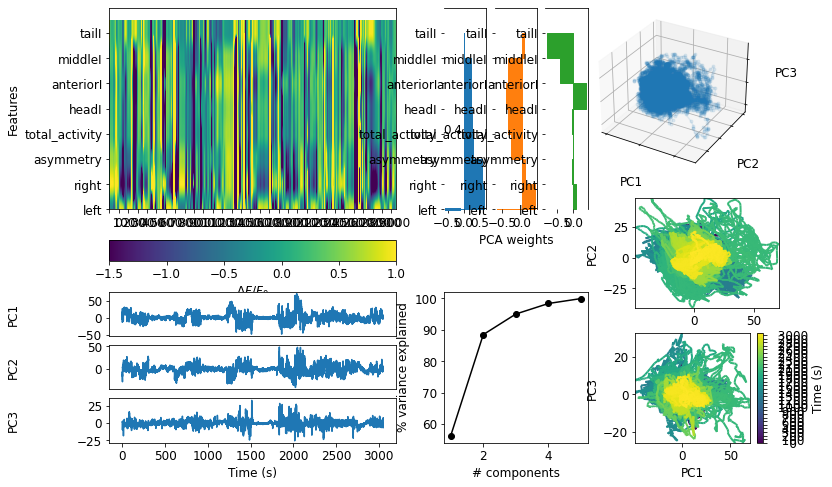

In [2401]:
data = df.values[:,:12]
principal_components_analysis(data[:, :8], sampling_rate=20, folder='all', columns = df.columns[:8].values)

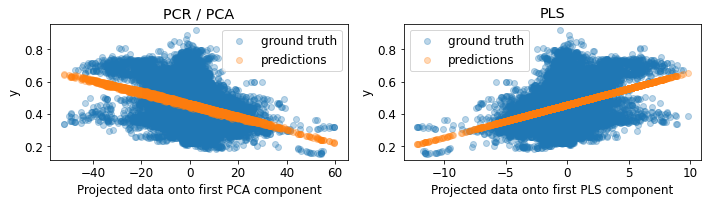

In [2402]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,:8]
y = df['velocity']
rng =13
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [2403]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.090
PLS r-squared 0.094


In [2279]:
df

,left,right,asymmetry,total_activity,headI,anteriorI,middleI,tailI,x_spot,y_spot,odor,Deltaodor,velocity
0,-0.283676,0.417648,-0.701324,0.066986,15.086304,8.877068,3.474564,2.608446,-11.014293,47.184884,91.104425,0.005917,0.524692
1,-0.178126,0.652395,-0.830521,0.237134,14.366570,10.393372,4.039083,2.462180,-11.119375,47.182415,91.096860,0.005875,0.525496
2,-0.730873,0.512404,-1.243277,-0.109234,12.820719,8.972359,2.919179,2.071056,-11.119375,47.182415,91.096860,0.005834,0.526284
3,-0.650611,0.810412,-1.461023,0.079901,11.495810,9.446055,3.892267,2.861980,-11.119375,47.182415,91.096860,0.005792,0.528583
4,-0.541542,1.042719,-1.584261,0.250588,13.248652,9.640517,3.944785,3.147983,-11.119375,47.182415,91.096860,0.005751,0.530838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,-16.149087,-13.031028,-3.118060,-14.590057,-9.427045,-7.271180,23.574850,43.963027,1.926736,-3.965770,99.922888,-0.000984,0.688887
6101,-14.024593,-10.655137,-3.369457,-12.339865,-8.530978,-6.132132,29.398263,40.623304,1.926736,-3.965770,99.922888,-0.000991,0.688064
6102,-13.473618,-8.031283,-5.442336,-10.752450,-3.969510,-3.564197,52.625425,35.482233,1.926736,-3.965770,99.922888,-0.000998,0.687221
6103,-14.263508,-8.350890,-5.912618,-11.307199,-1.090540,0.370170,51.549274,31.966229,1.926736,-3.965770,99.922888,-0.001005,0.686358


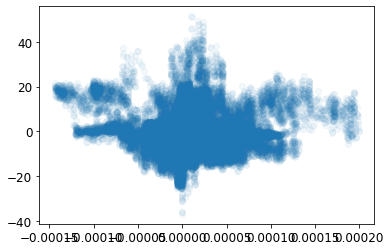

In [2404]:
plt.scatter(df['Deltaodor']/df['odor'], df['headI'], alpha=0.05)

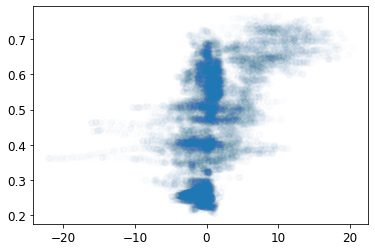

In [2405]:
for idx, item in engineered.items():
    item = item[300:2000]
    plt.scatter(item['total_activity'], item['velocity'], color='C0', alpha=0.01)